# Analysis of Earthquake Frequency
By Royce Schultz

## Abstract

This project will demonstrate the effectiveness of common statistical distributions at modeling random natural phenomena.

## The exponential distribution

Marginal Distribution:
\begin{align}
    e^{-\lambda x}
\end{align}
Cumulative Distribution:
\begin{align}
    \int Marginal\ Dist = 1 - e^{-\lambda x}
\end{align}

In [1]:
def exp_marginal_density(x, lamb): # The derivative of CDF
    return lamb * np.exp(-lamb * x)

def exp_cumulative_density(x, lamb): # The integral of MDF
    return 1 - np.exp(-lamb * x)

The exponential distribution models the time **between** events, but it can be transformed to model the **number of events** in each timestep.

## The Poisson Distribution

In [2]:
def pois_marginal_density(k,lamb):
    a = lamb**k
    b = np.exp(-lamb)
    c = gamma(k+1)
    return (a * b) / c

def pois_cumulative_density(k,lamb):
    s = 0
    for x in range(k):
        s += np.exp(-lamb)*(lamb**x)/gamma(k+1)
    return s

## About the data

The dataset is available on [Kaggle](https://www.kaggle.com/usgs/earthquake-database)

The filtered set contains 23228 earthquakes from all over the world reported between 1965 and 2016. This set only contains significant earthquakes with a magnitude >5.5. There are **thousands** of small, unnoticable earthquakes every day that are not contained in this set.

| Magnitude | Effects | Estimated Number Each Year | 
|---|---|---|
| <2.5 | Usually not felt, only recorded by seismograph. | 900,000 | 
| 2.5-5.4 | Often felt, but only minor damage | 30,000 | 
|  5.5-6.0 | Slight damage to buildings | 500 | 
|  6.1-6.9 | May cause lots of damage in populated areas | 100 | 
|  7.0-7.9 | Serious Damage | 20 | 
|  >8.0 | Can totally destroy communities | 1 every 5-10 years | 

[(Source, geo.mtu.edu)](http://www.geo.mtu.edu/UPSeis/magnitude.html)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.special import gamma

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Reading and processing the data

In [4]:
Fields = ['Date','Time','Latitude','Longitude','Type','Magnitude','Source'] # Only import used columns
df = pd.read_csv('database.csv', usecols=Fields)

In [5]:
# Cleaning
df = df[df.Date.str.len() < 15] # Removes 3 rows with malformed dates
df = df[df.Type.isin(['Earthquake'])] # removes nuclear explosions and rock bursts

In [6]:
# Calculations
df['Datetime'] = pd.to_datetime(df.Date +' '+ df.Time) #convert strings to datetime object
df['Year'] = df['Datetime'].map(lambda x: x.year) #get year of datetime object for plotting

#for grouping magnitudes
df['Rounded_Magnitude'] = np.floor(df.Magnitude * 2) / 2 #scaling rounds to the nearest half instad of whole number.

df['Last_Quake'] = df.Datetime.diff() #get frequency data
df = df[df['Last_Quake'].notna()]
df['Last_Quake_days'] = df['Last_Quake'].map(lambda x: x.total_seconds()/(24*60*60)) # Convert to days

df.reset_index(drop=True, inplace=True)

In [7]:
df.head()

,Date,Time,Latitude,Longitude,Type,Magnitude,Source,Datetime,Year,Rounded_Magnitude,Last_Quake,Last_Quake_days
0,01/04/1965,11:29:49,1.863,127.352,Earthquake,5.8,ISCGEM,1965-01-04 11:29:49,1965,5.5,1 days 21:45:31,1.906609
1,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,6.2,ISCGEM,1965-01-05 18:05:58,1965,6.0,1 days 06:36:09,1.275104
2,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,5.8,ISCGEM,1965-01-08 18:49:43,1965,5.5,3 days 00:43:45,3.030382
3,01/09/1965,13:32:50,11.938,126.427,Earthquake,5.8,ISCGEM,1965-01-09 13:32:50,1965,5.5,0 days 18:43:07,0.779942
4,01/10/1965,13:36:32,-13.405,166.629,Earthquake,6.7,ISCGEM,1965-01-10 13:36:32,1965,6.5,1 days 00:03:42,1.002569


## Fitting the data to the statistical Model

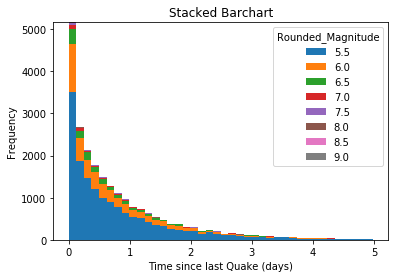

In [8]:
(df[df.Last_Quake_days < 5].pivot(columns='Rounded_Magnitude')['Last_Quake_days']).plot(kind = 'hist', stacked=True,bins=40)
plt.title('Stacked Barchart')
plt.xlabel('Time since last Quake (days)')
plt.show()

## Global Exponential Model

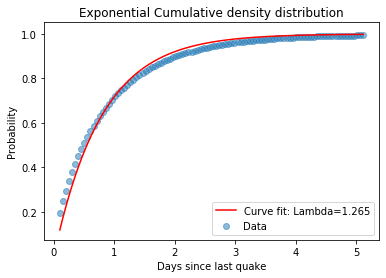

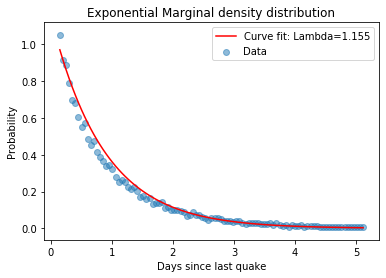

lambda (avg): 1.209864762554936


In [9]:
density = 100 # Plot resolution
lamb = []
# This is okay becuase data is so dense. When data is more sparce, other methods must be used.

# Cumulative Distribution
max_x = df.Last_Quake_days.max()
x = np.linspace(0.1,.5*max_x,density) # x does not include 0 to avoid skewing data during derivative
y = np.zeros(density)
for i in range(density):
    y[i] = len(df[df.Last_Quake_days < x[i]]) / len(df) # Count earthquakes less than tolerance, divide by size of list to get probability
# Plot data
plt.scatter(x,y, alpha=0.5, label='Data') 
# Fit curve
popt, pcov = curve_fit(exp_cumulative_density, x, y) 
plt.plot(x, exp_cumulative_density(x, *popt), 'r-',label='Curve fit: Lambda=%5.3f' % tuple(popt)) # Plot fit curve
lamb.append(popt)

plt.title('Exponential Cumulative density distribution')
plt.xlabel('Days since last quake')
plt.ylabel('Probability')
plt.legend()

#Marginal Distribution
plt.figure() # New plot
dx = np.diff(x)
dy = np.diff(y)
new_x = x[1:] # becuase np.diff()

plt.scatter(new_x,dy/dx, alpha=0.5, label='Data') # Plot data

popt, pcov = curve_fit(exp_marginal_density, new_x, dy/dx) # Fit curve
plt.plot(new_x, exp_marginal_density(new_x, *popt), 'r-',label='Curve fit: Lambda=%5.3f' % tuple(popt)) # Plot fit curve
lamb.append(popt)

plt.title('Exponential Marginal density distribution')
plt.xlabel('Days since last quake')
plt.ylabel('Probability')
plt.legend()

plt.show()

global_lamb = np.mean(lamb)
print('lambda (avg): ' + str(global_lamb))


### Mean and Variance

The exponential distribution has the propterty,

\begin{align}
mean = \frac{1}{\lambda} \\
variance = \frac{1}{\lambda}
\end{align}

Using $\lambda = avg(1.265,1.155) = 1.210$, **on average** earthquakes occour every 0.826 days. This closely agreees with the calculated mean of the dataset with small error.

In [10]:
mean = df.Last_Quake_days.mean()
error = abs(mean - (1/global_lamb))/ mean
print('mean: %3.3f, error %3.3f' % (mean,error))

mean: 0.818, error 0.011


### Probability of a week without a strong earthquake

In [11]:
print('P(Days >= 7) = %3.3f percent' %((1 - exp_cumulative_density(7,global_lamb))*100))

P(Days >= 7) = 0.021 percent


## The Poisson Distribution

Using the lambda from the exponential distribution fitting, the Poisson distribution can be easily calcualted.

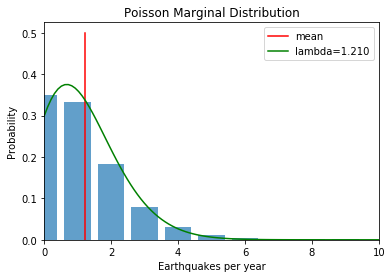

In [12]:
max_x = df['Last_Quake_days'].max()
x = np.linspace(0,max_x,density)

plt.plot([global_lamb,global_lamb],[0,.5], label='mean',c='r') # Mark mean
plt.plot(x,pois_marginal_density(x,global_lamb),label = 'lambda=%3.3f'%(global_lamb), c='g')

plt.title('Poisson Marginal Distribution')
plt.xlabel('Earthquakes per year')
plt.ylabel('Probability')
plt.legend()

counts = df.Date.groupby(df.Date).count().value_counts()
total_days = int((df.Datetime.max()-df.Datetime.min())/np.timedelta64(1,'D'))
days_w_no_quake = total_days - df.Date.nunique()
counts[0] = days_w_no_quake
plt.bar(counts.index, counts/total_days, alpha=0.7)
plt.xlim(0,10)
plt.show()

The Poisson distribution has the propterty,

\begin{align}
mean = \lambda \\
variance = \lambda
\end{align}

So, **on average** earth will have 1.210 eathquakes **per day**.

### Probability of 1 or more quakes in a day

In [13]:
print('P(Quake > 1) = %3.3f percent' %((1 - pois_cumulative_density(1,global_lamb))*100))

P(Quake > 1) = 70.176 percent


## Localizing the model

Earthquakes are more common at intersections of tectonic plates. Filtering the data to a local area can help residents assess and prepare for earthquakes.

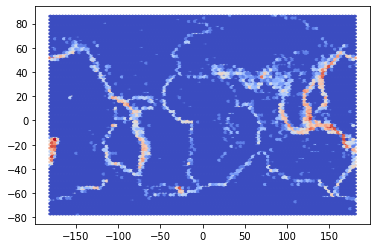

In [14]:
plt.hexbin(df.Longitude.values,df.Latitude.values, gridsize=100, bins='log',cmap='coolwarm')

### Map of tectonic plates

![Tectonic Plates Map](tectonic-plates.jpg)

## Filtering by local distance

### About the distance Funciton
Subtracting latitude and longitude of a quake will not return the distance. The data will be skewed due to the same effect that makes Greenland appear nearly as large as Africa on a 2d map.

Instead Lat/Long points define a point in spherical space and can be converted to an x,y,z triple in cartesian space. Then the euclidian distance between quakes and the reference point can be accuratly calculated.


In [15]:
#   Determines Euclidian (straight line) between 2 points. Does not consider arc length, just straight distance
#   So the poles are 2 units apart, the equator is sqrt(2)*r from each pole, not pi*r and pi/2*r like it would be with arc distance
def distance_from(df, Lat, Long):
    Lat = np.deg2rad(Lat) # Convert degrees to radians for numpy trig
    Long = np.deg2rad(Long)
    earth_radius = 6371 # km
    x_pos = earth_radius * np.cos(Lat)*np.sin(Long) # Convert spherical coordinates to cartesian
    y_pos = earth_radius * np.cos(Lat)*np.cos(Long) # Assumes earths radius = 1
    z_pos = earth_radius * np.sin(Lat)
    
    data_Latitude_rad = np.deg2rad(df.Latitude) # Convert dataframe to radians
    data_Longitude_rad = np.deg2rad(df.Longitude)
    data_x_pos = earth_radius * np.cos(data_Latitude_rad)*np.sin(data_Longitude_rad) # Convert to spherical
    data_y_pos = earth_radius * np.cos(data_Latitude_rad)*np.cos(data_Longitude_rad)
    data_z_pos = earth_radius * np.sin(data_Latitude_rad)
    return ( (data_x_pos - x_pos)**2 + (data_y_pos - y_pos)**2 + (data_z_pos - z_pos)**2)**(1/2) # Pythagoras3D

### Sampling some cities

In [16]:
Tokyo = [35.67,139.65]
San_Fran = [37.77,-122.42]
Denver = [39.74,-104.99]

df['Dist_Tokyo'] = distance_from(df,Tokyo[0],Tokyo[1])
df['Dist_San_Fran'] = distance_from(df,San_Fran[0],San_Fran[1])
df['Dist_Denver'] = distance_from(df,Denver[0],Denver[1])

df.reset_index(drop=True, inplace=True)

df.head()

,Date,Time,Latitude,Longitude,Type,Magnitude,Source,Datetime,Year,Rounded_Magnitude,Last_Quake,Last_Quake_days,Dist_Tokyo,Dist_San_Fran,Dist_Denver
0,01/04/1965,11:29:49,1.863,127.352,Earthquake,5.8,ISCGEM,1965-01-04 11:29:49,1965,5.5,1 days 21:45:31,1.906609,3903.666462,10086.546238,10844.773500
1,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,6.2,ISCGEM,1965-01-05 18:05:58,1965,6.0,1 days 06:36:09,1.275104,7431.237762,7829.511117,8857.842876
2,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,5.8,ISCGEM,1965-01-08 18:49:43,1965,5.5,3 days 00:43:45,3.030382,12419.068617,11354.027774,10996.431875
3,01/09/1965,13:32:50,11.938,126.427,Earthquake,5.8,ISCGEM,1965-01-09 13:32:50,1965,5.5,0 days 18:43:07,0.779942,2928.373019,9672.115135,10417.868876
4,01/10/1965,13:36:32,-13.405,166.629,Earthquake,6.7,ISCGEM,1965-01-10 13:36:32,1965,6.5,1 days 00:03:42,1.002569,5914.613093,8504.900890,9565.323488


### How far away can you feel a strong quake?
The [US Geological Program (USGS)](https://earthquake.usgs.gov/learn/topics/mag-intensity/) cites that even somewhat large earhquakes dissapate quickly over an area. The tremors can hardly be felt more than just 100km or about 1 degree away.

![Quake Strength Map](Quake_Strength_Heatmap.jpg)

There are clearly other factors to consider before estimating damages. Soil composition can affect energy dissapation and other secondary effects like tsunamis can cause significant damage from greater distances.

In [17]:
# distance_from returns a the distance in kilometers between 2 points.
# Euclidian distance, not arc distance
q = pd.DataFrame.from_dict({'Latitude': [San_Fran[0]], 'Longitude': [San_Fran[1]]})
distance_from(q,34.05,-118.24) # Distance to LA

0    558.990744
dtype: float64

## Comparing the frequency of earthquakes in 3 large cities.

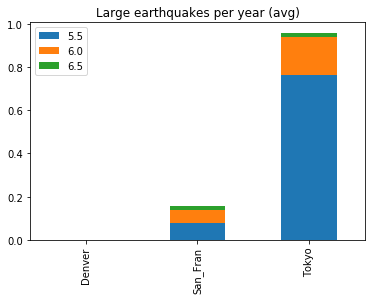

In [18]:
Local_Dist = 100
years = 2016-1965

Denver_Local_Counts = df[df.Dist_Denver < Local_Dist].Rounded_Magnitude.value_counts() / years
San_Fran_Local_Counts = df[df.Dist_San_Fran < Local_Dist].Rounded_Magnitude.value_counts() / years
Tokyo_Local_Counts = df[df.Dist_Tokyo < Local_Dist].Rounded_Magnitude.value_counts() / years

counts = pd.concat({'Denver':Denver_Local_Counts, 'San_Fran':San_Fran_Local_Counts, 'Tokyo':Tokyo_Local_Counts}, axis = 1).fillna(0)
counts.transpose().plot(kind='bar',stacked=True)

plt.title('Large earthquakes per year (avg)')
plt.show()


### Earthquake frequency in Tokyo

In [19]:
tokyo_df = df[df.Dist_Tokyo < Local_Dist]
# Calculations
tokyo_df['Last_Quake'] = tokyo_df.Datetime.diff()
tokyo_df = tokyo_df[tokyo_df['Last_Quake'].notna()]
tokyo_df['Last_Quake_years'] = tokyo_df['Last_Quake'].map(lambda x: x.total_seconds()/(365*24*60*60)) # Last Quake (s)

tokyo_df.reset_index(drop=True, inplace=True)
tokyo_df.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Time,Latitude,Longitude,Type,Magnitude,Source,Datetime,Year,Rounded_Magnitude,Last_Quake,Last_Quake_days,Dist_Tokyo,Dist_San_Fran,Dist_Denver,Last_Quake_years
0,09/15/1967,00:28:39,35.607,140.738,Earthquake,5.8,ISCGEM,1967-09-15 00:28:39,1967,5.5,891 days 18:56:40,1.241238,98.569397,7644.968728,8474.988294,2.443258
1,07/01/1968,10:45:12,35.999,139.348,Earthquake,6.1,ISCGEM,1968-07-01 10:45:12,1968,6.0,290 days 10:16:33,4.794919,45.601298,7706.335966,8517.359487,0.795694
2,07/22/1971,22:07:21,35.518,138.976,Earthquake,5.6,ISCGEM,1971-07-22 22:07:21,1971,5.5,1116 days 11:22:09,1.419352,63.242601,7752.862234,8563.203859,3.058832
3,09/30/1973,06:17:53,35.606,140.447,Earthquake,5.9,US,1973-09-30 06:17:53,1973,5.5,800 days 08:10:32,0.695035,72.374801,7662.202260,8488.883038,2.192714
4,10/01/1973,14:16:23,35.716,140.561,Earthquake,5.6,US,1973-10-01 14:16:23,1973,5.5,1 days 07:58:30,1.332292,82.428106,7649.836055,8476.991232,0.003650


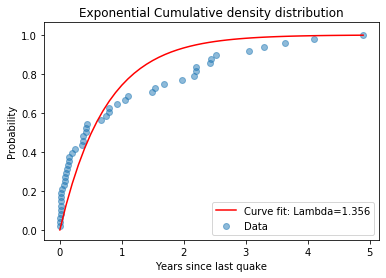

In [20]:
# Cumulative Distribution
max_x = tokyo_df.Last_Quake_years.max()
x = np.array(sorted(tokyo_df.Last_Quake_years.values))
y = np.arange(1,len(tokyo_df)+1)/len(tokyo_df)
dense_x = np.linspace(0,max_x,50)

plt.scatter(x,y, alpha=0.5, label='Data') # Plot data

popt, pcov = curve_fit(exp_cumulative_density, x, y) # Fit curve
plt.plot(dense_x, exp_cumulative_density(dense_x, *popt), 'r-',label='Curve fit: Lambda=%5.3f' % tuple(popt)) # Plot fit curve
tokyo_lamb = popt[0]

plt.title('Exponential Cumulative density distribution')
plt.xlabel('Years since last quake')
plt.ylabel('Probability')
plt.legend()

In [21]:
len(tokyo_df)

48

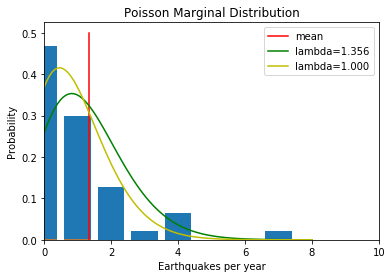

In [26]:

x = np.linspace(0,8,100)

plt.plot([tokyo_lamb,tokyo_lamb],[0,.5], label='mean',c='r') # Mark mean
plt.plot(x,pois_marginal_density(x,tokyo_lamb),label = 'lambda=%3.3f'%(tokyo_lamb), c='g')
manual_fit = 1
plt.plot(x,pois_marginal_density(x,manual_fit),label = 'lambda=%3.3f'%(manual_fit), c='y')

plt.title('Poisson Marginal Distribution')
plt.xlabel('Earthquakes per year')
plt.ylabel('Probability')
plt.legend()

years = tokyo_df.Datetime.map(lambda x: x.year)
total_years = years.max()-years.min()
years_w_no_quake = total_years - years.nunique()
counts = years.groupby(years).count().value_counts()
counts[0] = years_w_no_quake
plt.bar(counts.index,counts/(years.max()-years.min()))

total_days = int((df.Datetime.max()-df.Datetime.min())/np.timedelta64(1,'D'))
days_w_no_quake = total_days - df.Date.nunique()
plt.bar(counts.index, counts/total_days, alpha=0.7)
plt.xlim(0,10)
plt.show()

In [25]:
print('P(Quake > 1, lambda = 1.35) = %3.3f percent' %((1 - pois_cumulative_density(1,tokyo_lamb))*100))
print('P(Quake > 1, lambda = 1) = %3.3f percent' %((1 - pois_cumulative_density(1,1))*100))

P(Quake > 1, lambda = 1.35) = 74.219 percent
P(Quake > 1, lambda = 1) = 63.212 percent


#### Fit

The global data is dense enough to sample at linearly spaced points, but this set is more sparse. Optimizing on this set suffers from sampling bias. Lambda ~= 1 visually appears to be a better fit. 

#### Tokyo Conclusions

Using the properties of Poisson distributions, Tokyo has on average **more than 1 large earthquakes per year.** The ancient, coastal city has been built from the ground up with the danger of earthquakes in mind. Traditionally, buildings in Tokyo were made of wood becuase the wood flexes during earthquakes instead of crumbling like bricks or concrete. However, wood building cause other forms of danger. In 1923, a **8.3** magnitude earthquake hit Tokyo. A fire had broken out in one of the wooden buildings and quickly spread throughout the city killing 142,000 people, more than the earthquake itself. ([source](https://historycollection.co/day-history-great-tokyo-fire-devastates-city-1923/))

Modern structures in Tokyo use elaborate damping methods to dissapate energy as it travels through the building.

![Dampers](damper.jpg)

Other solutions completely isolate the building from the ground by sitting on rollers.

![Rollers](rollers.jpg)